Univariate Analysis
=========

In [1]:
import pandas as pd
import code.univariate as uni
import numpy as np

Data
----

In [2]:
german_scorecard = pd.read_csv('data/GermanScoreCard.csv',sep=";")
pol_comps = pd.read_csv('data/1year.csv')

Method
----

In univariate analysis we wanto to assess:
- quality of data (missings, outliers, irregularities in variable distribution)
- initially assess explanatory power of variable
- discuss definition of variable in context of model use
- define and assess theoretical expected dependence between the variable and the default probability

Discrete variable
------------------
**Example: Savings account/bonds**

We expect that people with higher saving value will be more reliable clients as they prove that have ability of generate financial surplus. 

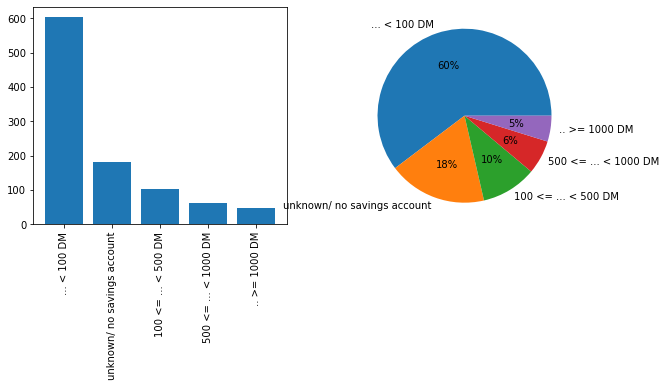

In [3]:
uni.DiscreteVariable.eda(german_scorecard['Savings account/bonds'])

**Discriminating power analysis**

- Top-left

Roc curve-> we replace values of categorical variable with Weights of Evidance: $WoE = \frac{Log(number of bads)}{Log(number of goods)}$. This changes categoircal values to numerical one that can be ordered. This allow us to plot ROC curve

- Top-right

AUC - Area under ROC Curve-> interpreted as probability that randomly chosen "good" will have higher value of WC2TA then randomly chosen "bad". AUC=50% no discrimination, AUC close to 0% or 100% good discrimination  

Gini - 2AUC-1, normilized AUC

Information Value - IV = $\sum WoE_i \times (\%goods_i - \%bads_i)$ where $i$ is a category


- Bottom-left

Bar plot of number of observation in each category with marked numbers of good and bads  

- Bottom-right


Bar plot of percentage of good and bads in each category  

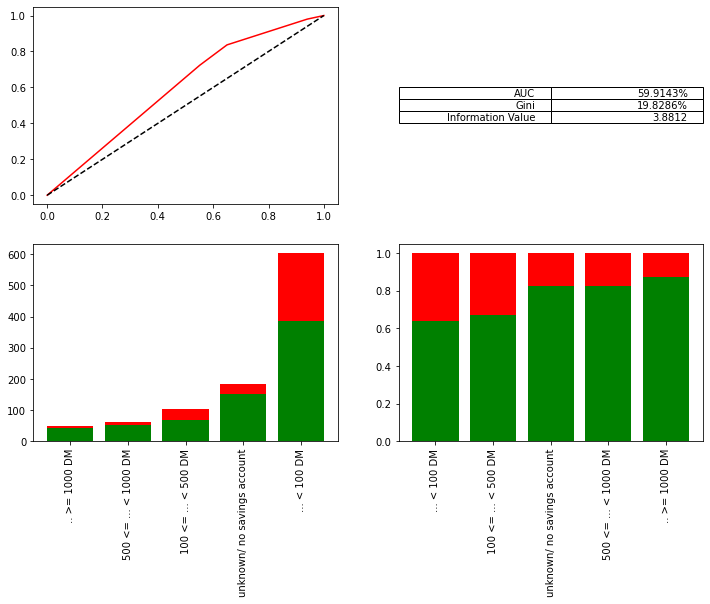

In [4]:
uni.DiscreteVariable.discrimination_analysis(
    german_scorecard[german_scorecard['Flag']==0]['Savings account/bonds'], 
    german_scorecard[german_scorecard['Flag']==1]['Savings account/bonds'])

Continuous Variable
------------------

**Example: working capital / total assets**

Working capital is the difference between a company’s current assets—such as cash, accounts receivable/customers’ unpaid bills, and inventories of raw materials and finished goods—and its current liabilities, such as accounts payable and debts. Working capital is a measure of a company’s liquidity, operational efficiency, and short-term financial health. If a company has substantial positive NWC, then it should have the potential to invest and grow 

We expect that companies with low WC (measured as percentage of TA) will default more frequently. 

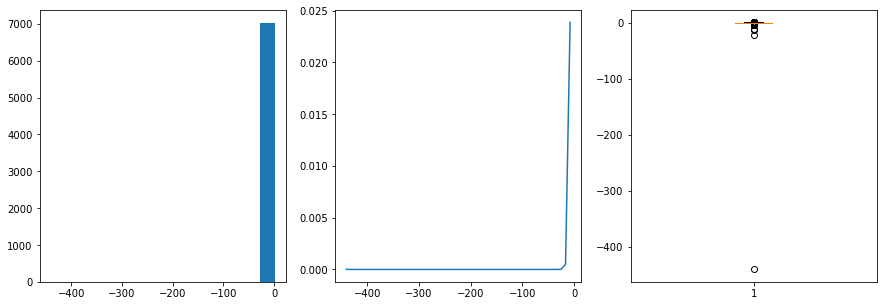

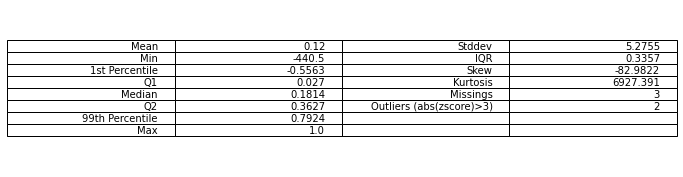

In [5]:
uni.ContinuousVariable.eda(pol_comps['working capital / total assets'])

Initial analysis showed large number of outliers and some missings values. We truncate values to 1st nad 99th percentile, and replace missings with median.

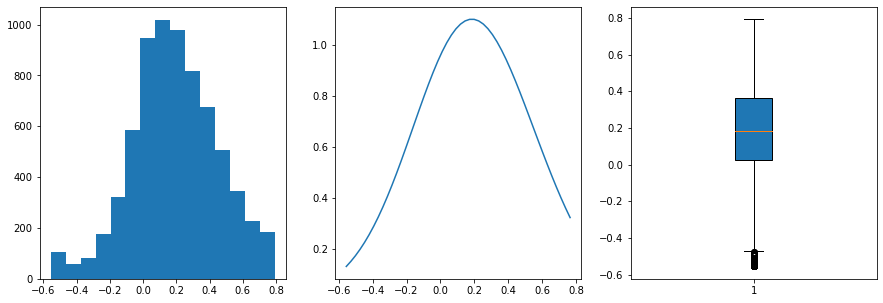

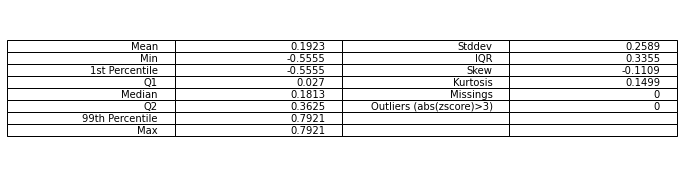

In [6]:
pmin = np.percentile(pol_comps['working capital / total assets'].dropna(), 1)
pmax = np.percentile(pol_comps['working capital / total assets'].dropna(), 99)
median = np.percentile(pol_comps['working capital / total assets'].dropna(), 50)


pol_comps['working capital / total assets'].fillna(median, inplace=True)

pol_comps['working capital / total assets'] = np.where(pol_comps['working capital / total assets'] < pmin, 
                                                pmin,
                                                pol_comps['working capital / total assets'])

pol_comps['working capital / total assets'] = np.where(pol_comps['working capital / total assets'] > pmax, 
                                                pmax,
                                                pol_comps['working capital / total assets'])

uni.ContinuousVariable.eda(pol_comps['working capital / total assets'])

**Discriminating power analysis**


* Top-Left (Histogram)

Assess shift of the populations (good/bad) relative to each other. Histogram helsp also to spot irregularities in distribution. Here for example large numbero of bad obs with very low WC2TA 

* Top-Centre (PDF KDE)

Similar to Histogram but smoother

* Top-Right (Boxplots)

Summurize the distribution by plotting: median, Q1, Q3 and outliers. Helping spot outliers. For example here we see that low values of WC2TA are outliers in good sample while high values of WC2TA are outliers in bad sample 

* Centre-Left (ROC Curve)

Assess discrimiation power 

* Centre-Centre (CDF)

Presents the empirical Cummulative Distribution Function. The Black Line marks largest distance (Kolmogorow-Smirnow Test) 

* Centre-Right (Discrimination stats)

AUC - Area under ROC Curve-> interpreted as probability that randomly chosen "good" will have higher value of WC2TA then randomly chosen "bad". AUC=50% no discrimination, AUC close to 0% or 100% good discrimination  

Gini - 2AUC-1, normilized AUC

Fisher Information =  $\frac{mean_{good}-mean_{bad}}{\sqrt{(\sigma_{good}+\sigma_{bad})/2}}$, Further from zero indicates larger shift between populations

Kolmogoro Smirnow = $max(CDF_{good} - CDF_{bad})$ Larger values indicate larger shift between population (marked wiht black line in central plot)

* Bottom-Left (Default Rate Curve)

Shows depenedence between variable and DR. During model development expected dependence between the accounting ratio and the default probability should be theoretically described and then empirically checked.

* Bottom-Centre (Linearity of logodds)

If we are usign logistic regression, we assume that logodds are linear in terms of variable. This plot helps us to check it, for example here we see some autoregression of residuals.

* Bottom-Right (Residuals of logodds)

Distribution of Residuals 


*Example of univariate analysis see: Chapter 5 in [1], Chapter 2.4.2 in [2]*

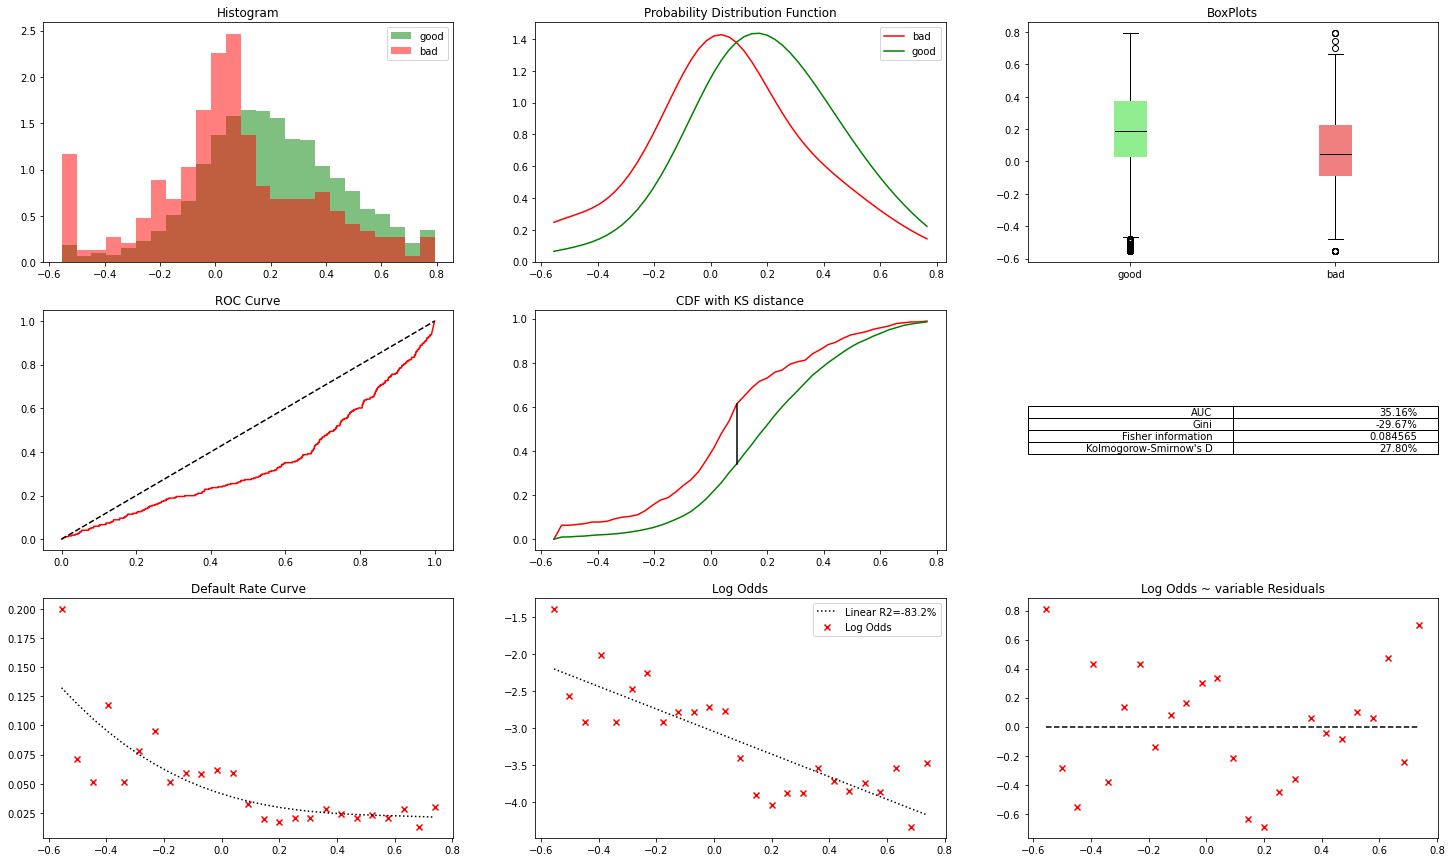

In [7]:
uni.ContinuousVariable.discrimination_analysis(
    pol_comps[pol_comps['defaul_flag']==0]['working capital / total assets'], 
    pol_comps[pol_comps['defaul_flag']==1]['working capital / total assets'],  
    hist_bin = 25, kde_smooth_param=0.5)

**Check discriminatory power on subsamples**

Basic assumption of the model is homogenity. For corporate rating models different subpopulations of companies might have different characteristics, depending on sector (banking, mining), age of company (start-ups), size (family companies vs international corps) or region. Discriminatory power should be check for selected subsamples

Here we divide sample basing on assets (more or less 1st quartile, 3rd quartile)  

In [8]:
pol_comps['Company_size'] = pol_comps['logarithm of total assets'].fillna(pol_comps['logarithm of total assets'].median())
pol_comps['Company_size'] = ["small" if np.exp(logTa) < 40 else
                             "medium" if np.exp(logTa) < 100 else 
                             "large"
                             for logTa in pol_comps['Company_size']]

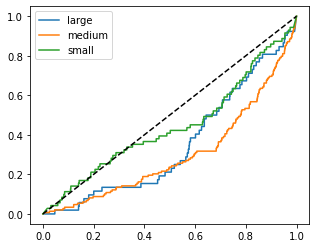

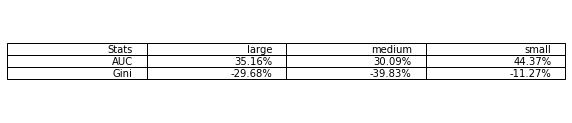

In [9]:
uni.ContinuousVariable.compare_discrimination_in_subpops(
    pol_comps,'working capital / total assets', 'defaul_flag', 'Company_size')

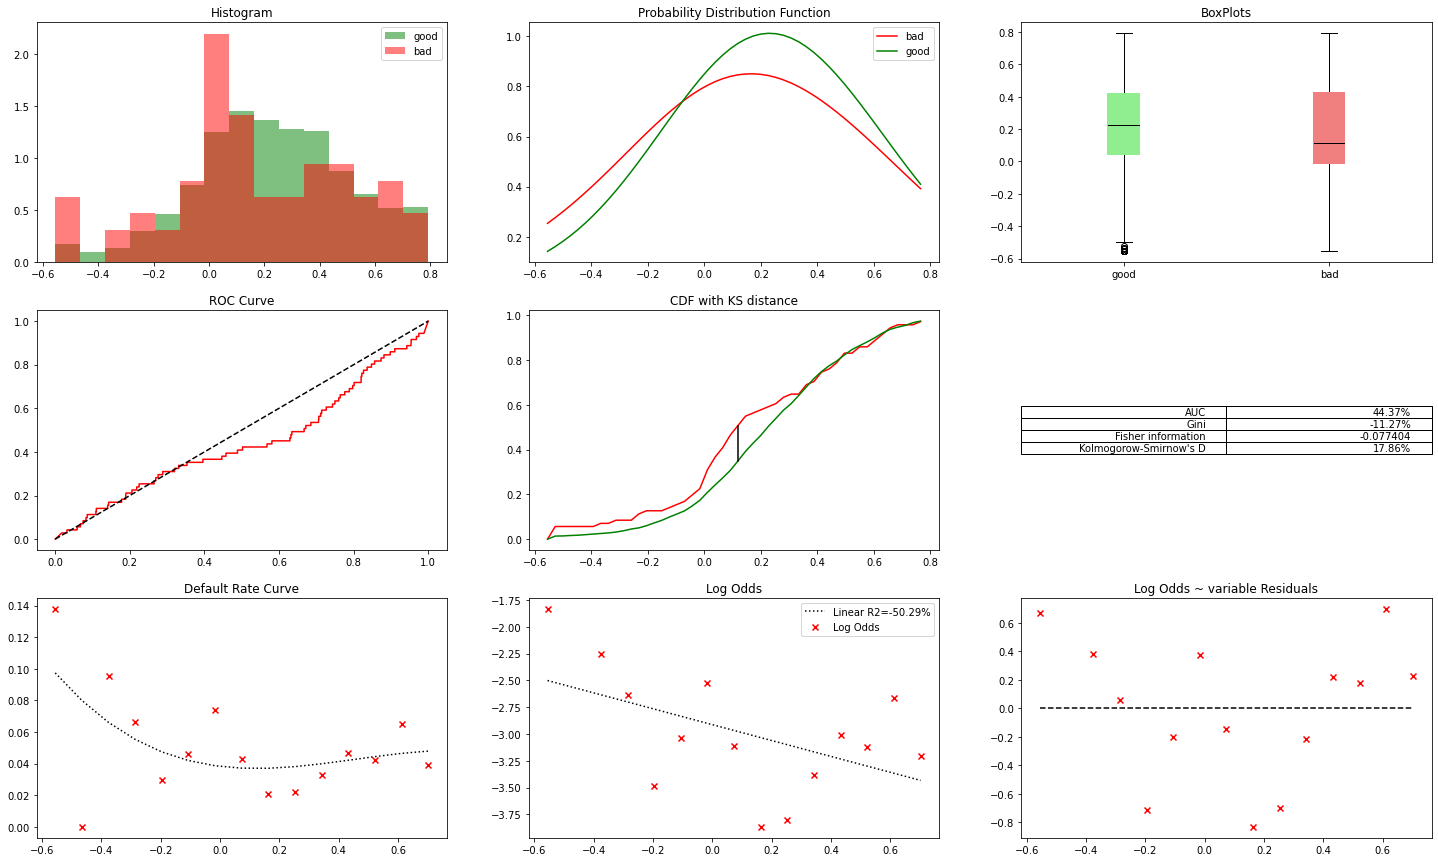

In [10]:
goods = pol_comps[(pol_comps['Company_size'] =="small") 
                  & (pol_comps['defaul_flag'] == 0)]['working capital / total assets']
bads = pol_comps[(pol_comps['Company_size'] =="small") 
                  & (pol_comps['defaul_flag'] == 1)]['working capital / total assets']
uni.ContinuousVariable.discrimination_analysis(goods, bads)

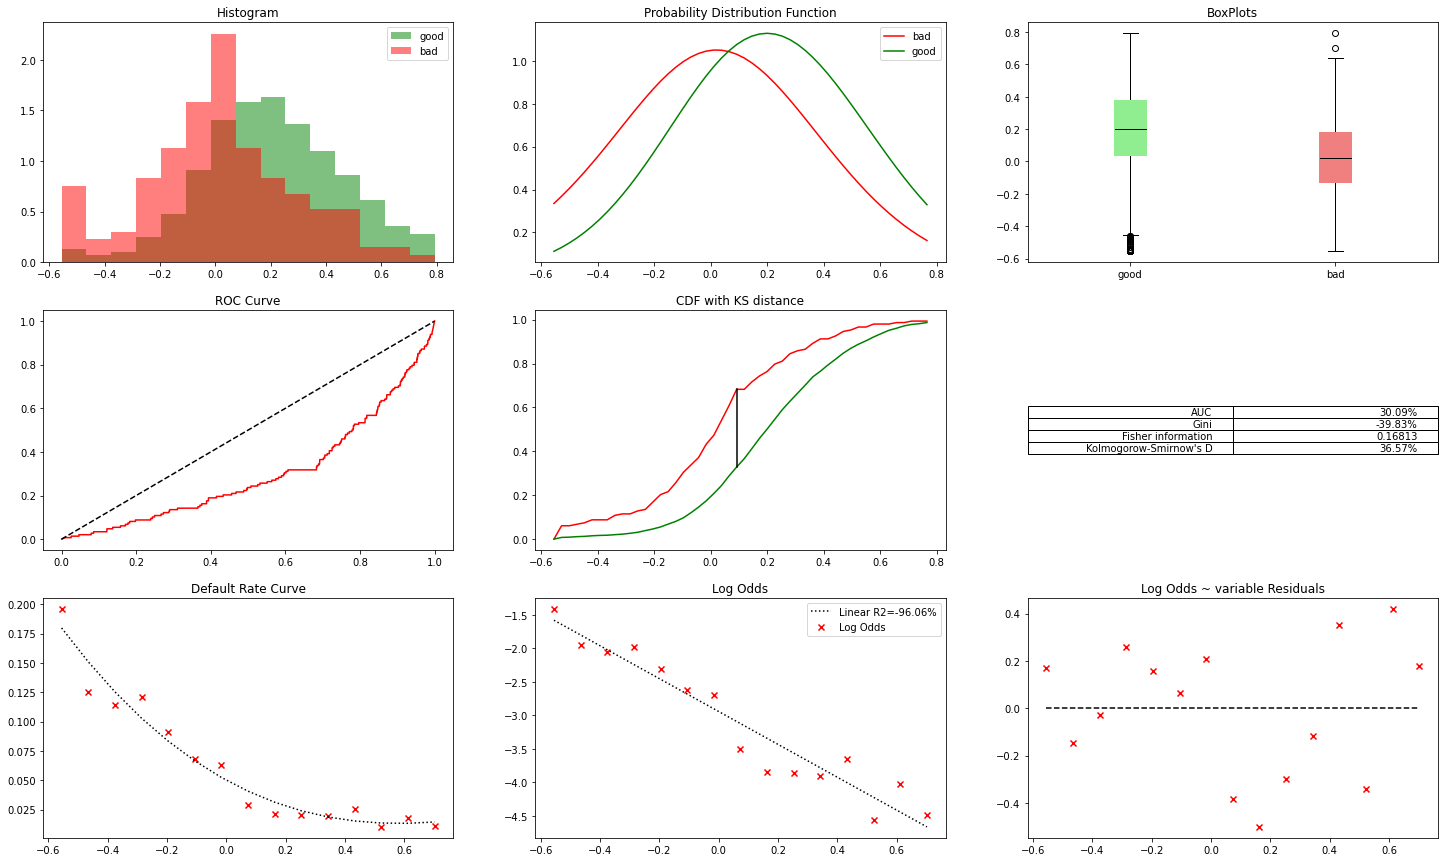

In [11]:
goods = pol_comps[(pol_comps['Company_size'] =="medium") 
                  & (pol_comps['defaul_flag'] == 0)]['working capital / total assets']
bads = pol_comps[(pol_comps['Company_size'] =="medium") 
                  & (pol_comps['defaul_flag'] == 1)]['working capital / total assets']
uni.ContinuousVariable.discrimination_analysis(goods, bads)

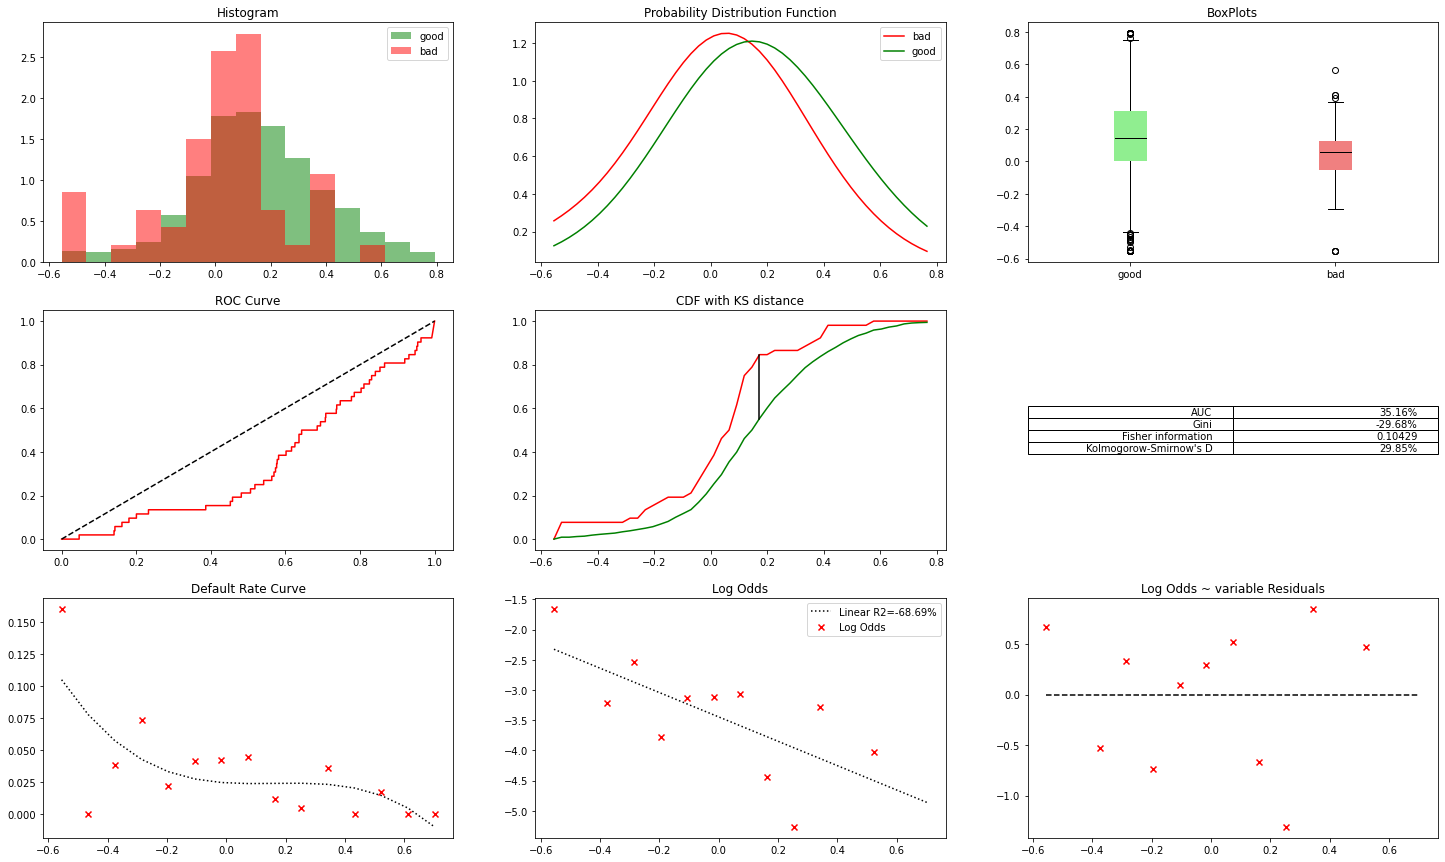

In [12]:
goods = pol_comps[(pol_comps['Company_size'] =="large") 
                  & (pol_comps['defaul_flag'] == 0)]['working capital / total assets']
bads = pol_comps[(pol_comps['Company_size'] =="large") 
                  & (pol_comps['defaul_flag'] == 1)]['working capital / total assets']
uni.ContinuousVariable.discrimination_analysis(goods, bads)

Example issues
----------------------

**Continuous or Discrete?**

Formally duration in month is continuous. But we clearly see humps in distribution. This is because loans are taken usually for 1Y, 2Y, 3Y etc., so we see humps (12M, 24M, 36M, 48M). This disturbes the distribution of variable. Supposly we should treat it as categorical varialbe (Lenght of credit <=1Y, between 1Y and 2Y, etc.

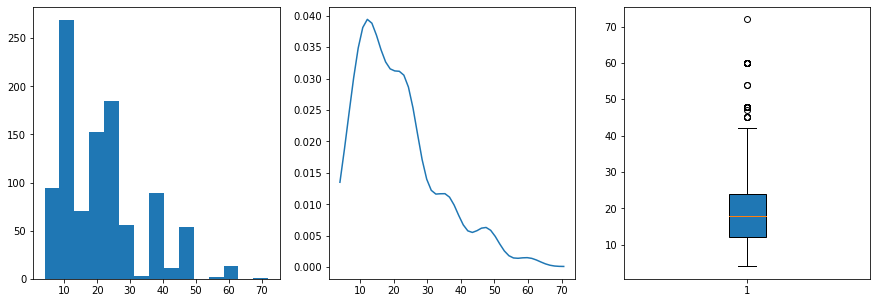

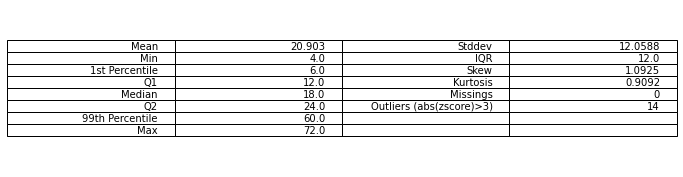

In [13]:
uni.ContinuousVariable.eda(german_scorecard['Duration in month'], 
                           hist_bin = 15, kde_smooth_param=0.3)

**Business assessment**

We see that longer credits are more probably to not being paid. We may ask: if less reliable customers taking longer loans, or during longer period of crediting it is more probably that customer defaults?

Business case: Analysis showed that morgages are usually not paid by people between 30y-40y. But we know that there is an effect of "matuiring the credit". Usually mortgageis not paid between 5th and 10th year of crediting and mortgage are ususally taken by people between 25Y-35Y.      

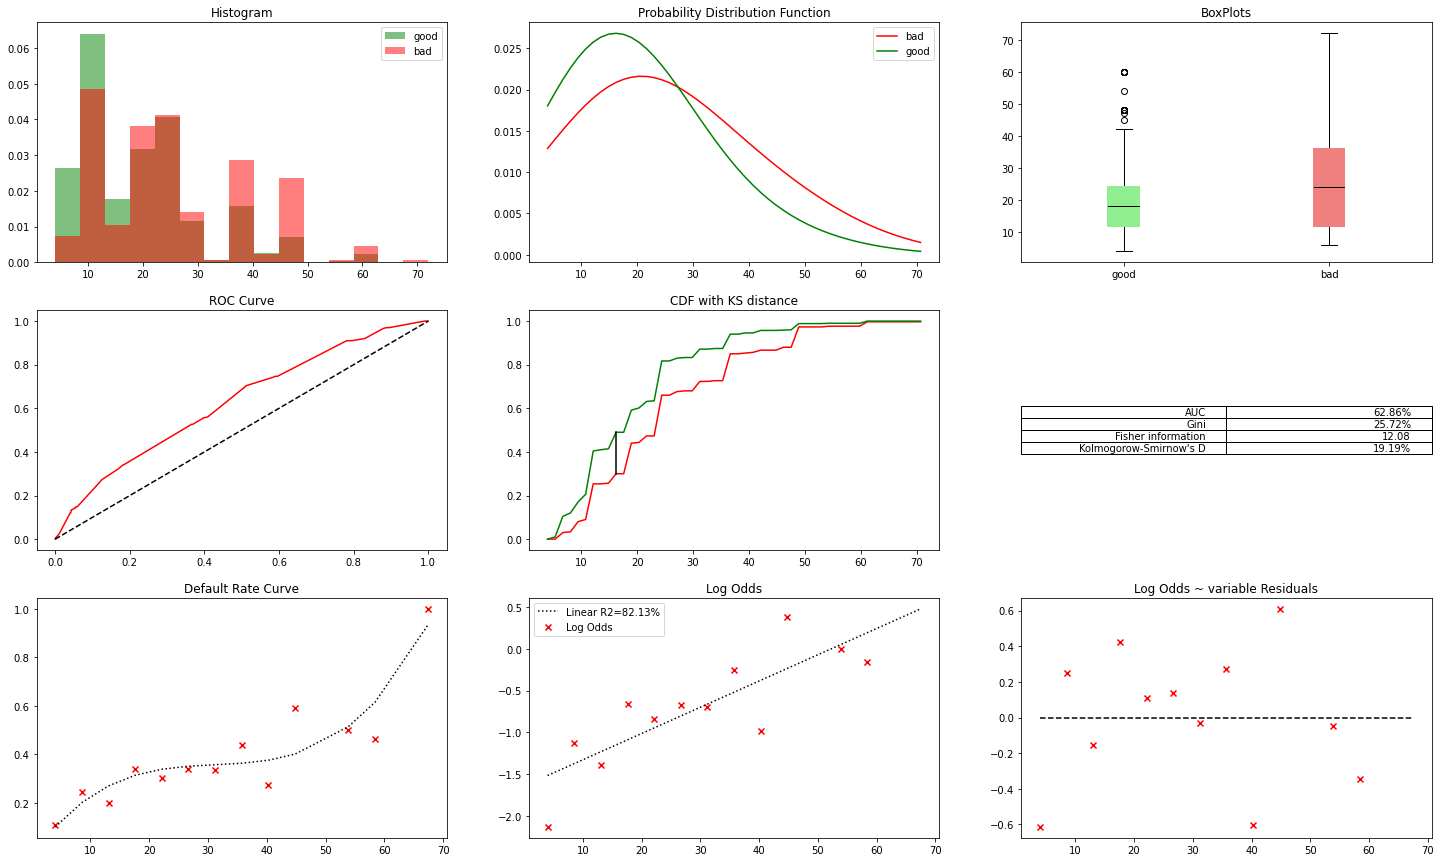

In [14]:
uni.ContinuousVariable.discrimination_analysis(
    german_scorecard[german_scorecard['Flag']==0]['Duration in month'], 
    german_scorecard[german_scorecard['Flag']==1]['Duration in month'],
    hist_bin = 15)

References
------------------

[1] The Bloomberg Corporate Default Risk Model (DRSK) for Public Firms

[2] The basel II risk parameters